In [14]:
import copy
import numpy as np
import pandas as pd
import scipy.optimize as opt
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline

In [44]:
# def ll4(x,b,c,d,e):
#     '''This function is basically a copy of the LL.4 function from the R drc package with
#      - b: hill slope
#      - c: min response
#      - d: max response
#      - e: EC50'''
#     return (c+(d-c)/(1+np.exp(b*(np.log(x)-np.log(e)))))


def ll4(conc, h, IC50):
    # print(conc)
    '''This function is basically a copy of the LL.4 function from the R drc package with
     - h: hill slope
     - a: min response
     - b: max response
     - IC50: IC50'''
    # return a+(b-a)/(1+np.exp(h*(np.log(conc)-np.log(IC50))))
    return 100- 100.0/(1+(conc/10**np.log10(IC50))**h)



def pDose(x):
    '''This is just a helper function, to compute easily log transformed concentrations used in drug discovery'''
    return(-np.log10(1e-6*x))

### Generating data

In [16]:
doses = np.append(np.arange(1,11), [15, 20, 25], axis=0)
# doses = np.arange(1, 100)
cmax = 2
concs = doses*cmax
concs

array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 30, 40, 50])

In [24]:
params = [
    { 'compound': 'dofetilide',  'h': 0.7712,   'IC50': 18.82 }

    # { 'compound': 'A',  'b': 1,    'c': 0,   'd': 100,  'e': 0.4,   'startDose': 10,  'nDose': 8,  'dilution': 3 },
    # { 'compound': 'B',  'b': 0.7,  'c': 0,   'd': 86,   'e': 1.3,   'startDose': 30,  'nDose': 8,  'dilution': 3 },
    # { 'compound': 'C',  'b': 2,    'c': 24,  'd': 152,  'e': 0.02,  'startDose': 3,   'nDose': 8,  'dilution': 3 }
]

# dilution 

In [25]:
drData=[]
for curve in params:        
    
    # generate base curve
    curData = pd.DataFrame(
        data={
            'compound':curve['compound'], 
            # 'dose':curve['startDose']/np.power(curve['dilution'], range(curve['nDose']))
            'dose': concs
        }        
    )    
    
    curData['logDose'] = pDose(curData.dose)
    curData['response'] = curData.dose.apply(lambda x: ll4(x,*[curve[i] for i in ['h', 'IC50']]))        
    
    # generate replicates
    repData = []
    for i in range(3):
        rep = copy.deepcopy(curData)
        if i>0 and i%2==1:            
            rep.response -= 0.25*np.random.normal(len(rep.response))                    
        elif i>0 and i%2==0:            
            rep.response += 0.25*np.random.normal(len(rep.response))        
        # for j in range(len(rep.response)):
        #     if rep.response[j] >100:
        #         rep.response[j] = 100
        # print(rep.response)
        repData.append(rep.copy())    
    repData = pd.concat(repData)    
    drData.append(repData)    
# assemble data
drData = pd.concat(drData)

drData.head(13)

,compound,dose,logDose,response
0,dofetilide,2,5.698970,84.926594
1,dofetilide,4,5.397940,76.750927
2,dofetilide,6,5.221849,70.715481
3,dofetilide,8,5.096910,65.920312
4,dofetilide,10,5.000000,61.955428
5,dofetilide,12,4.920819,58.590213
6,dofetilide,14,4.853872,55.679616
7,dofetilide,16,4.795880,53.125668
8,dofetilide,18,4.744727,50.858808
9,dofetilide,20,4.698970,48.827757


In [26]:
compoundData = drData.groupby(['compound'])
fitData = []
for name,group in compoundData:
    fitCoefs, covMatrix = opt.curve_fit(ll4, group.dose, group.response, p0=(0.5, 100), bounds=([0, 1e-10], [10, 1e+10]), method='trf')
    print(fitCoefs)
    resids = group.response-group.dose.apply(lambda x: ll4(x,*fitCoefs))
    curFit = dict(zip(['h', 'IC50'], fitCoefs))
    curFit['compound']=name
    curFit['residuals']=sum(resids**2)
    fitData.append(curFit)
fitCompound = [ item['compound'] for item in fitData]
fitCompound

[ 0.77178652 18.9310236 ]


['dofetilide']

In [27]:
fitTable = pd.DataFrame(fitData).set_index('compound')
fitTable

,h,IC50,residuals
compound,,,
dofetilide,0.771787,18.931024,266.371974


In [28]:
fitTable = pd.DataFrame(fitData).set_index('compound')
paramTable = pd.DataFrame(params).set_index('compound')[['h', 'IC50']]
paramTable.columns = ['ref_'+i for i in paramTable.columns]
fitTable.join(paramTable)

,h,IC50,residuals,ref_h,ref_IC50
compound,,,,,
dofetilide,0.771787,18.931024,266.371974,0.7712,18.82


C:\Anaconda3\envs\ml\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


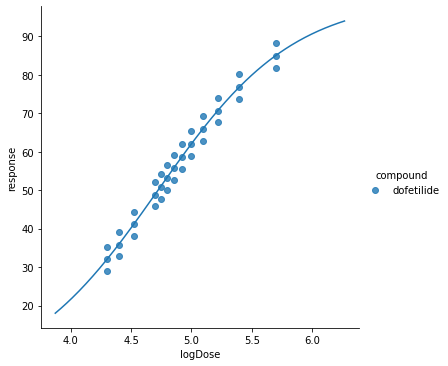

In [29]:
refDose = np.linspace(min(drData.logDose)*0.9,max(drData.logDose)*1.1,256)
refDose = (10**-refDose)*1e6
sns.lmplot('logDose','response',data=drData,hue='compound',fit_reg=False)
for fit in fitData:
    # plt.plot([pDose(i) for i in refDose], [ll4(i,*[fit[i] for i in ['h','a','b','IC50']]) for i in refDose])
    plt.plot([pDose(i) for i in refDose], [ll4(i,*[fit[i] for i in ['h', 'IC50']]) for i in refDose])

In [107]:
concs =  np.array([1 ,1 ,1, 2, 2, 2, 3, 3, 3, 6, 6, 6]) 	
blocks = np.array([4.3, 5.9, 3.9, 20.9, 16.9, 14.3, 26.9, 28.4, 14.3, 34.9, 24.1, 22.1])
print(concs.shape, blocks.shape)

(12,) (12,)


In [108]:
xvals = np.array([1, 2, 3, 6])
# xvals = np.array([xvals.min(), xvals.max(), plot_IC50/10, plot_IC50*10])
xvals = np.array([xvals.min(), xvals.max()])
xvals

array([1, 6])

In [109]:
plot_x = np.linspace(min(np.log10(xvals)), max(np.log10(xvals)),  100)
plot_x = 10**plot_x
plot_x

array([1.        , 1.01826335, 1.03686025, 1.0557968 , 1.07507919,
       1.09471374, 1.11470688, 1.13506517, 1.15579526, 1.17690396,
       1.19839817, 1.22028494, 1.24257143, 1.26526495, 1.28837293,
       1.31190294, 1.33586268, 1.36026001, 1.38510292, 1.41039954,
       1.43615817, 1.46238723, 1.48909532, 1.5162912 , 1.54398376,
       1.57218208, 1.60089539, 1.63013311, 1.6599048 , 1.69022023,
       1.72108932, 1.75252218, 1.78452911, 1.81712059, 1.85030731,
       1.88410012, 1.91851011, 1.95354853, 1.98922688, 2.02555683,
       2.06255029, 2.10021937, 2.13857641, 2.17763399, 2.21740489,
       2.25790213, 2.299139  , 2.34112898, 2.38388584, 2.42742359,
       2.47175648, 2.51689904, 2.56286606, 2.60967258, 2.65733395,
       2.70586578, 2.75528396, 2.80560468, 2.85684443, 2.90901998,
       2.96214844, 3.0162472 , 3.07133399, 3.12742684, 3.18454414,
       3.24270459, 3.30192725, 3.36223151, 3.42363713, 3.48616422,
       3.54983327, 3.61466512, 3.68068102, 3.7479026 , 3.81635

In [110]:
plot_IC50 = 18.82	
plot_h = 0.7712
plot_y = ll4(plot_x, plot_h, plot_IC50)
plot_y

array([ 9.41989711,  9.53966772,  9.66079875,  9.78330152,  9.90718731,
       10.03246741, 10.15915309, 10.28725558, 10.41678609, 10.54775582,
       10.6801759 , 10.81405745, 10.94941154, 11.08624919, 11.22458139,
       11.36441906, 11.50577306, 11.64865419, 11.79307321, 11.93904076,
       12.08656745, 12.23566378, 12.3863402 , 12.53860703, 12.69247453,
       12.84795284, 13.00505201, 13.16378197, 13.32415255, 13.48617345,
       13.64985424, 13.81520439, 13.98223321, 14.15094986, 14.32136339,
       14.49348266, 14.6673164 , 14.84287317, 15.02016136, 15.19918918,
       15.37996466, 15.56249567, 15.74678985, 15.93285466, 16.12069736,
       16.310325  , 16.50174439, 16.69496215, 16.88998465, 17.08681804,
       17.2854682 , 17.4859408 , 17.68824123, 17.89237463, 18.09834586,
       18.30615954, 18.51581996, 18.72733117, 18.94069691, 19.15592061,
       19.37300541, 19.59195414, 19.8127693 , 20.03545308, 20.26000733,
       20.48643357, 20.71473297, 20.94490636, 21.17695421, 21.41

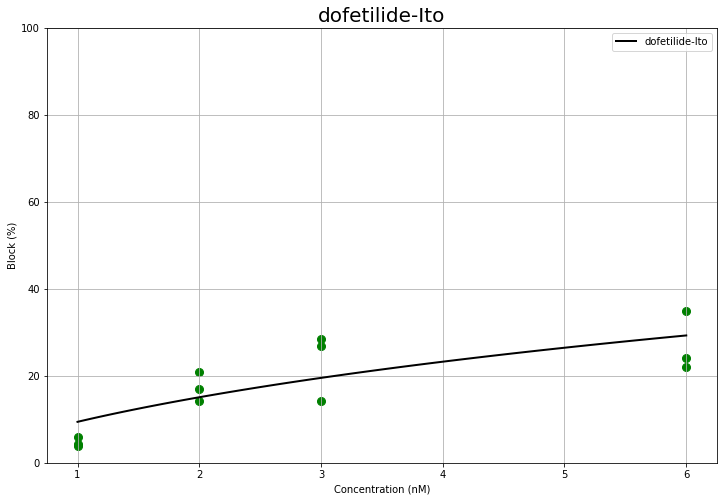

In [117]:
drug_channel = "dofetilide-Ito"
fig, ax = plt.subplots(1,1, figsize=(12,8))    
ax.set_title(drug_channel, fontsize=20)
ax.set_xlabel(f'Concentration (nM)')  
ax.set_ylabel(f'Block (%)')  
ax.set_ylim(0, 100)    
ax.plot( plot_x, plot_y, label=drug_channel, color='k', linewidth=2)         
ax.scatter(concs, blocks, s=64, color='g')
ax.legend()
ax.grid()
plt.plot
fig.savefig(f"{drug_channel}.jpg", dpi=100)

In [118]:
concs =  np.array([5, 5, 5, 50, 50, 50, 150, 150, 150, 150, 500, 500, 500, 1000, 1000, 1000]) 	
blocks = np.array([6.5, 4.3, 1.1, 22.6, 20.9, 19.4, 50.5, 28.9, 40.1, 35.9, 89.8, 67.2, 68.9, 99.6, 77.7, 79.7 ])
print(concs.shape, blocks.shape)

(16,) (16,)


In [119]:
xvals = np.array([5, 50, 150, 500, 1000])
# xvals = np.array([xvals.min(), xvals.max(), plot_IC50/10, plot_IC50*10])
xvals = np.array([xvals.min(), xvals.max()])
plot_x = np.linspace(min(np.log10(xvals)), max(np.log10(xvals)),  100)
plot_x = 10**plot_x

plot_IC50 = 201.8	
plot_h = 1.097
plot_y = ll4(plot_x, plot_h, plot_IC50)

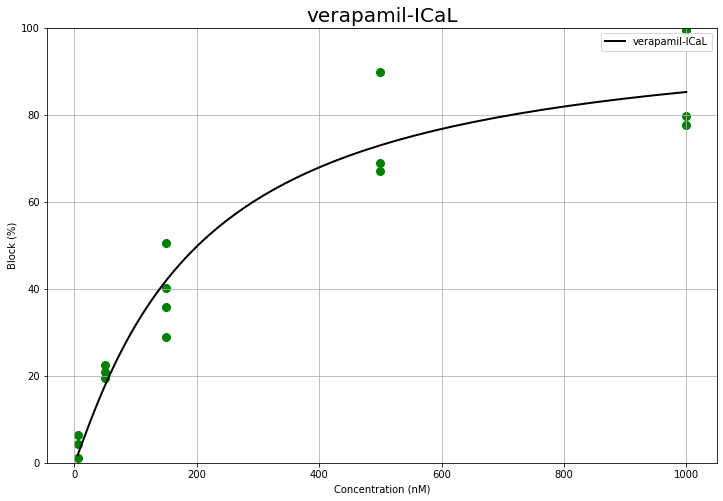

In [120]:
drug_channel = "verapamil-ICaL"
fig, ax = plt.subplots(1,1, figsize=(12,8))    
ax.set_title(drug_channel, fontsize=20)
ax.set_xlabel(f'Concentration (nM)')  
ax.set_ylabel(f'Block (%)')  
ax.set_ylim(0, 100)    
ax.plot( plot_x, plot_y, label=drug_channel, color='k', linewidth=2)         
ax.scatter(concs, blocks, s=64, color='g')
ax.legend()
ax.grid()
plt.plot
fig.savefig(f"{drug_channel}.jpg", dpi=100)